# 🩺 Predikcija dijabetesa – odbrana projekta

**Autor:** _Milica Bosančić SV60/2022_

**Predmet:** Računarske inteligencije


## **Cilj projekta** 
Cilj projekta je da se na osnovu medicinskih parametara kao što su glukoza, pritisak i BMI, napravi model koji može da predvidi da li osoba ima povećan rizik od dijabetesa.  

## 📋Opis skupa podataka i priprema

Osobine koje se koriste u modelu su:

- **Broj trudnoća**  
- **Glukoza**  
- **Krvni pritisak**  
- **Debljina kože**  
- **Insulin**  
- **BMI (Body Mass Index)**  
- **Porodični faktor dijabetesa**  
- **Godine starosti**

Ciljna promenljiva je kolona **`Outcome`**, gde:
- `0` označava da osoba *nema dijabetes*  
- `1` označava da osoba *ima dijabetes*

---

### 📊 Podela skupa podataka

Skup je **stratifikovano** podeljen u odnosu na ciljnu klasu:
- **70%** – trening skup  
- **15%** – validacioni skup  
- **15%** – test skup  

Ova podela osigurava da je **raspodela klasa (0/1)** približno ista u svim podskupovima, što je važno da modeli uče i testiraju se na uravnotežen način.

---


### 🧹 Obrada nedostajućih vrednosti

Nule u kolonama gde **nula nije realna fiziološka vrednost** (npr. *glukoza*, *krvni pritisak*, *insulin*, *debljina kože*) tretirane su kao **nedostajuće vrednosti** (*missing values*). 
Zatim se računa **mediana** (koja ignoriše `NaN` vrednosti), te se sve `NaN` vrednosti zamenjuju se medianom.

---


### Razdvajanje osobina i ciljne promenljive 
   - `X` → sve kolone osim `Outcome`  
   - `y` → kolona `Outcome`  

---


### Kreiranje skupova 
   - `X_train`, `y_train` → učenje  
   - `X_val`, `y_val` → praćenje validacionog gubitka (npr. kod MLP-a ili logističke regresije)  
   - `X_test`, `y_test` → konačna evaluacija i poređenje modela  

---


### Čuvanje pripremljenih skupova(opciono) u folderu `outputs/` da bi se kasnije mogli koristiti bez ponovnog procesiranja.


> Napomena: Notebook je koncizan i fokusiran na priču i rezultate. Detaljniji kod je u `src/` modulima,
dok se u notebook-u pozivaju gotove funkcije i prikazuju rezultati.

## 1️⃣ Postavljanje okruženja
Kratki importi i postavljanje seed-a radi reproduktivnosti.

In [ ]:
import os, json, numpy as np
from src.utils import prepare_dataset, class_balance, FEATURES
from src.train_eval import train_and_evaluate_all
from src.plotting import generate_all_plots
from src.infer import predict_single

np.random.seed(42)
DATA_CSV = 'data/diabetes.csv'
OUT_DIR = 'outputs'
print('OK: imports ready')

OK: imports ready


## 2️⃣ Kratki pregled skupa podataka
- Pima Indians Diabetes dataset
- Stratifikovan split 70/15/15
- Zero→NaN u medicinski relevantnim kolonama
- Median imput + standardizacija po train-u

Napomena: obrada je implementirana u `src/utils.py`.

In [ ]:
ds = prepare_dataset(DATA_CSV, seed=42)
print('Oblici (train/val/test):', ds.X_train.shape, ds.X_val.shape, ds.X_test.shape)
print('Balans klasa (train):', class_balance(ds.y_train))
print('Feature kolone:', FEATURES)

Oblici (train/val/test): (536, 8) (115, 8) (116, 8)
Balans klasa (train): {0: 0.6511194029850746, 1: 0.34888059701492535}
Feature kolone: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


## 3️⃣ Treniranje i evaluacija modela
Treniramo četiri modela (Naive Bayes, KNN, Logistic Regression, MLP). Prag (threshold) se bira na **validacionom** skupu maksimizacijom **F1**; izveštavamo metrike na **test** skupu.

### 🔹 KNN (K-nearest neighbors)
KNN je **model bez eksplicitnog učenja** – on samo pamti podatke iz trening skupa.  
Kada treba da predvidi klasu za novi primer, on pronalazi **K najbližih primera** po rastojanju (npr. euklidskom)  
i odlučuje na osnovu **većinske klase** među njima.  
Što su vrednosti osobina bliže, to je veća verovatnoća da pripadaju istoj klasi.  
Zbog toga je **standardizacija podataka** ključna da bi svaka osobina imala jednak doprinos.

---

### 🔹 Naivni Bajes (GaussianNB)
Naivni Bajes koristi **Bajesovu teoremu** kako bi izračunao verovatnoću da primer pripada određenoj klasi.  
Naziva se *naivan* jer pretpostavlja da su sve osobine međusobno **nezavisne** (što u praksi nije uvek tačno).  
Za svaku klasu računa se **sredina i varijansa** osobina (pretpostavlja se Gaussova raspodela).  
Model je **brz, jednostavan i stabilan**, posebno na manjim skupovima podataka.

---

### 🔹 Logistička regresija
Ovaj model uči **linearnu granicu odlučivanja** između klasa.  
Umesto da direktno predviđa 0 ili 1, on izračunava **verovatnoću klase 1** pomoću **sigmoid funkcije**  
koja vrednosti mapira u opseg (0, 1).  
Trening se zasniva na minimizaciji **binary cross-entropy** gubitka uz opcionalnu **L2 regularizaciju**  
koja sprečava prenaučenost i stabilizuje težine.

---

### 🔹 MLP (Multi-Layer Perceptron)
MLP je jednostavna **neuronska mreža** koja se sastoji od jednog ili više skrivenih slojeva neurona.  
Svaki neuron računa **linearnu kombinaciju ulaza** i zatim prolazi kroz **nelinearnu aktivacionu funkciju** (npr. ReLU).  
Model se trenira metodom **gradijentnog spuštanja**, gde se težine iterativno prilagođavaju tako da se smanji gubitak.  
Zahvaljujući nelinearnosti, MLP može da nauči **složenije odnose** među atributima od linearnih modela.


Izlaz: `outputs/summary.json` i `outputs/summary.csv` + per-model fajlovi.

In [ ]:
results = train_and_evaluate_all(csv_path=DATA_CSV, out_dir=OUT_DIR, seed=42)
with open(os.path.join(OUT_DIR, 'summary.json'), 'r', encoding='utf-8') as f:
    summary = json.load(f)
summary

[{'model': 'NaiveBayes',
  'threshold': 0.1720510351533513,
  'val_f1': 0.723404255319149,
  'val_auc': 0.8396666666666666,
  'val_ap': 0.6768147630658893,
  'test_f1': 0.6,
  'test_auc': 0.7697368421052632,
  'test_ap': 0.6297567482280795},
 {'model': 'KNN',
  'threshold': 0.25,
  'val_f1': 0.6938775510204082,
  'val_auc': 0.8009999999999999,
  'val_ap': 0.5919111846692933,
  'test_f1': 0.6875000000000001,
  'test_auc': 0.8274671052631579,
  'test_ap': 0.6764943314398849},
 {'model': 'LogReg',
  'threshold': 0.22970082880704762,
  'val_f1': 0.7676767676767676,
  'val_auc': 0.8673333333333333,
  'val_ap': 0.7441858776113951,
  'test_f1': 0.5981308411214953,
  'test_auc': 0.7848684210526317,
  'test_ap': 0.6620165883272728},
 {'model': 'MLP',
  'threshold': 0.2546423140698295,
  'val_f1': 0.6363636363636365,
  'val_auc': 0.784,
  'val_ap': 0.6995363005680433,
  'test_f1': 0.6097560975609756,
  'test_auc': 0.7743421052631578,
  'test_ap': 0.663959246376225}]

## 4️⃣ Tabela rezultata (val/test)
Kratak pregled ključnih metrika po modelu.

In [ ]:
from pprint import pprint
def fmt(x):
    return '-' if x is None else (f'{x:.3f}' if isinstance(x,(int,float)) else str(x))
headers = ['Model','Thr','Val F1','Val AUC','Val AP','Test F1','Test AUC','Test AP']
rows = []
for s in summary:
    rows.append([
        s['model'],
        fmt(s['threshold']), fmt(s['val_f1']), fmt(s['val_auc']), fmt(s['val_ap']),
        fmt(s['test_f1']), fmt(s['test_auc']), fmt(s['test_ap'])
    ])
colw = [max(len(h), max(len(str(r[i])) for r in rows)) for i,h in enumerate(headers)]
line = '+' + '+'.join(['-'*(w+2) for w in colw]) + '+'
print(line)
print('|'+'|'.join([' '+headers[i].ljust(colw[i])+' ' for i in range(len(headers))])+'|')
print(line)
for r in rows:
    print('|'+'|'.join([' '+str(r[i]).ljust(colw[i])+' ' for i in range(len(headers))])+'|')
print(line)
# Najbolji po Test F1, tie-break AUC
best = None
for s in summary:
    if best is None or (s['test_f1']>best['test_f1']) or (abs(s['test_f1']-best['test_f1'])<1e-9 and s['test_auc']>best['test_auc']):
        best = s
print('\n🏆 Best model:', best['model'], f"(test F1={fmt(best['test_f1'])}, AUC={fmt(best['test_auc'])}, AP={fmt(best['test_ap'])})")

+------------+-------+--------+---------+--------+---------+----------+---------+
| Model      | Thr   | Val F1 | Val AUC | Val AP | Test F1 | Test AUC | Test AP |
+------------+-------+--------+---------+--------+---------+----------+---------+
| NaiveBayes | 0.172 | 0.723  | 0.840   | 0.677  | 0.600   | 0.770    | 0.630   |
| KNN        | 0.250 | 0.694  | 0.801   | 0.592  | 0.688   | 0.827    | 0.676   |
| LogReg     | 0.230 | 0.768  | 0.867   | 0.744  | 0.598   | 0.785    | 0.662   |
| MLP        | 0.255 | 0.636  | 0.784   | 0.700  | 0.610   | 0.774    | 0.664   |
+------------+-------+--------+---------+--------+---------+----------+---------+

🏆 Best model: KNN (test F1=0.688, AUC=0.827, AP=0.676)


## 5️⃣ Grafici (ROC / Precision–Recall / konfuzione matrice)
Generišemo grafikone i prikažemo ih iz `outputs/`.

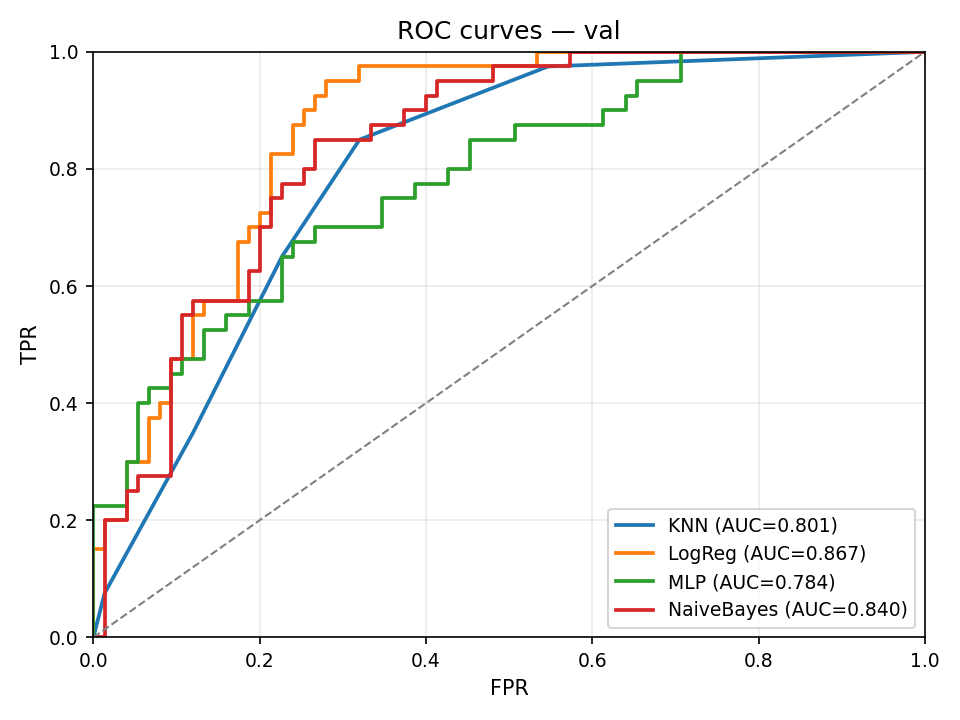

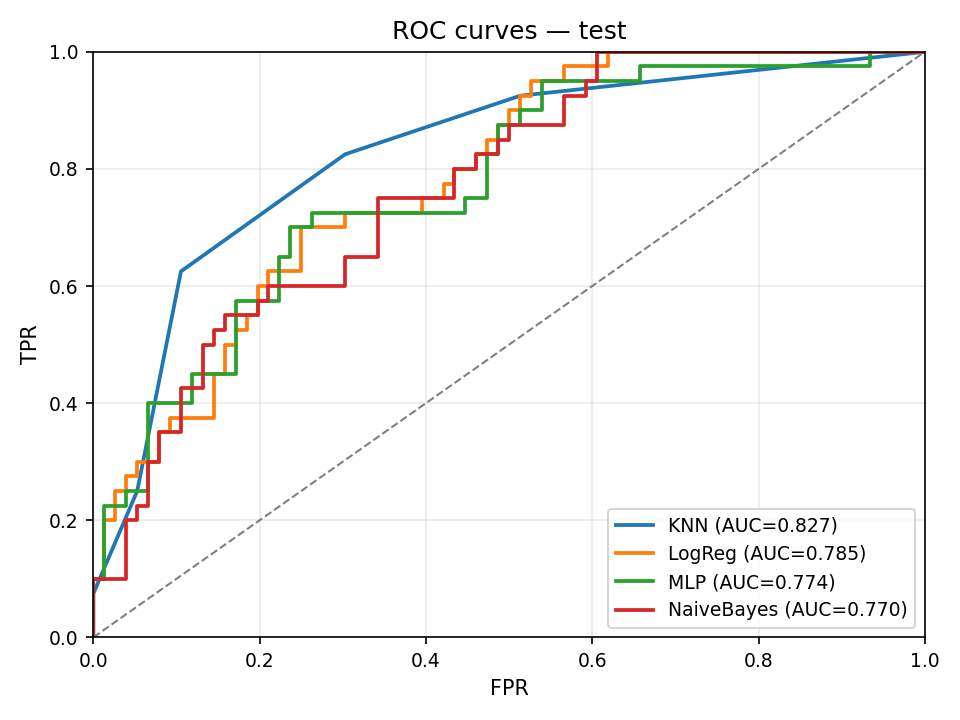

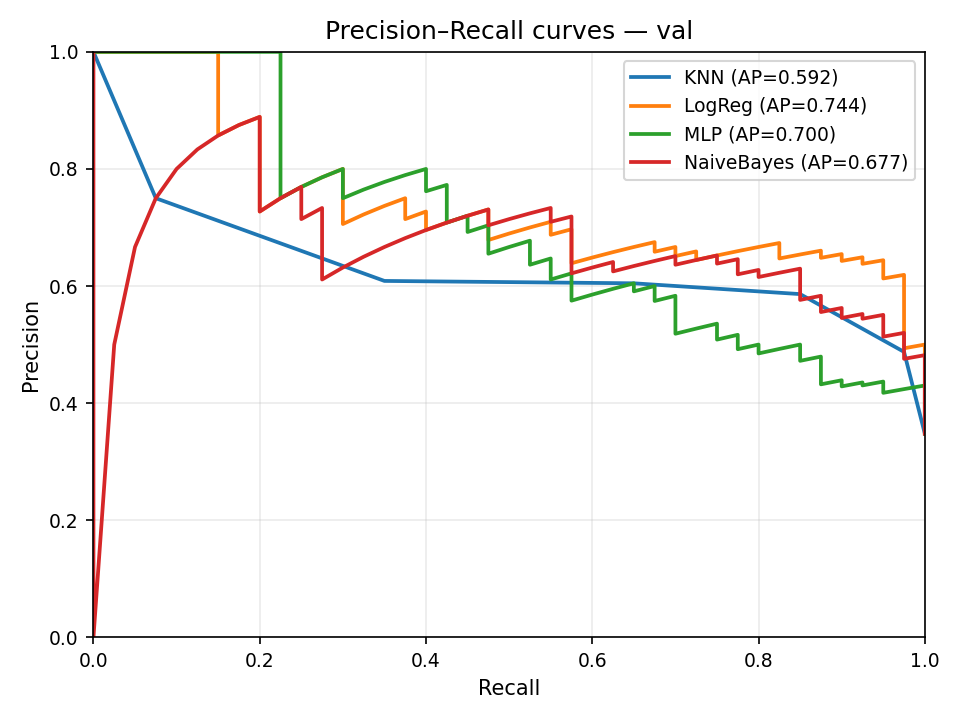

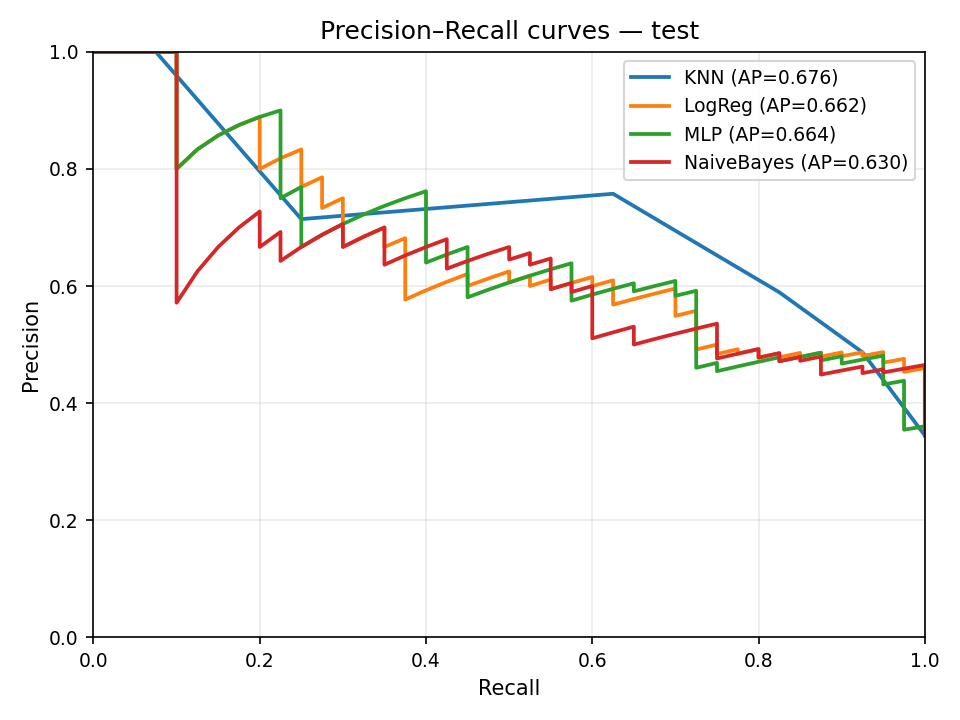

In [ ]:
generate_all_plots(outputs_dir=OUT_DIR)
import IPython.display as disp
for fn in ['ROC_curves_val.png','ROC_curves_test.png','Precision–Recall_curves_val.png','Precision–Recall_curves_test.png']:
    p = os.path.join(OUT_DIR, fn)
    if os.path.isfile(p):
        display(disp.Image(filename=p))

### 🔹 ROC krive (Validation i Test)

- **ROC krive** pokazuju koliko dobro model razdvaja pozitivne i negativne primere kroz sve moguće pragove odlučivanja.  
- Na **validation skupu**, **Logistička regresija (AUC = 0.867)** i **Naivni Bajes (AUC = 0.840)** postižu najviši AUC,  
  što znači da najbolje razdvajaju klase tokom učenja i validacije.  
- Na **test skupu**, **KNN (AUC = 0.827)** daje najbolju generalizaciju, dok su ostali modeli vrlo blizu  
  (LogReg ≈ 0.785, MLP ≈ 0.774, NaiveBayes ≈ 0.770). 

### 🔹 Precision–Recall krive
- Precision–Recall grafikon je posebno koristan kod nebalansiranih klasa, jer pokazuje odnos između  
  **preciznosti (tačnost pozitivnih predikcija)** i **odziva (koliko pozitivnih primera model pronalazi)**.  
- Na **validation skupu**, **Logistička regresija (AP = 0.744)** ima najbolji balans između preciznosti i odziva,  
  dok su **MLP (0.700)** i **Naivni Bajes (0.677)** odmah iza.  
  KNN ima nešto niži prosečan AP (0.592), što ukazuje da je osetljiviji na promenu praga.  
- Na **test skupu**, razlike su manje izražene — svi modeli imaju sličan nivo performansi  
  (KNN 0.676, LogReg 0.662, MLP 0.664, NB 0.630), što potvrđuje da generalizacija nije narušena.

## 6️⃣ Demo: unos jednog pacijenta i odluka modela
Primer kako korisnik može uneti svoje podatke i dobiti procenu rizika. Model/family se bira na osnovu najboljeg iz `summary.json` (može se fiksirati i ručno).

In [ ]:
example = {
    'Pregnancies': 2,
    'Glucose': 130,
    'BloodPressure': 72,
    'SkinThickness': 35,
    'Insulin': 100,
    'BMI': 30.5,
    'DiabetesPedigreeFunction': 0.45,
    'Age': 35,
}
res = predict_single(example, csv_path=DATA_CSV, outputs_dir=OUT_DIR, family=None)
label = 'POVIŠEN RIZIK' if res['label']==1 else 'nema povišen rizik'
print('Model:', res['family'])
print('Threshold:', f"{res['threshold']:.4f}")
print('Score:', f"{res['score']:.4f}")
print('Decision:', label)

Model: KNN
Threshold: 0.2500
Score: 0.2857
Decision: POVIŠEN RIZIK


## 7️⃣  Zaključak
- Najbolji model prema **test F1** (tie-break AUC) je prikazan gore.
- ROC i PR krive potvrđuju sposobnost razdvajanja klasa.
- Threshold je biran na validacionom skupu maksimizacijom F1.

**Ograničenja:** dataset je mali i klasa 1 je ređa; accuracy nije najbolja metrika → koristimo F1/Recall.